In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import os
os.chdir('/content/gdrive/My Drive/Deep Learning/Code')

import pandas as pd
import numpy as np
df = pd.read_pickle('Final_processed.pkl')
X = df['image_pixel']
y = df['high_sale']
X = X.to_numpy()
X = np.stack(X, axis=0)

Mounted at /content/gdrive


<ipython-input-2-8025e9c6e938>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='high_sale', palette=['blue', 'orange'])


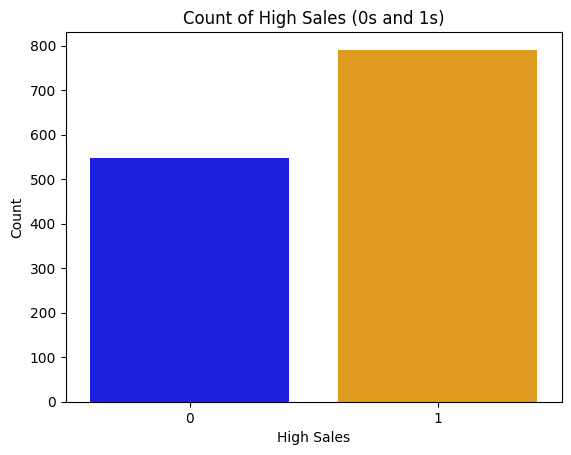

In [ ]:
# Plotting with Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='high_sale', palette=['blue', 'orange'])
plt.xlabel('High Sales')
plt.ylabel('Count')
plt.title('Count of High Sales (0s and 1s)')
plt.show()

In [ ]:
def augment_minority(X, y):

    datagen = ImageDataGenerator(
        rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
    )

    # Find minority class
    minority_class = 0 if np.sum(y == 0) < np.sum(y == 1) else 1
    majority_class = 1 - minority_class

    # Get minority samples
    X_minority = X[y == minority_class]
    y_minority = y[y == minority_class]

    # Calculate samples needed
    n_minority = len(X_minority)
    n_majority = np.sum(y == majority_class)
    n_to_generate = n_majority - n_minority

    # Generate augmented images
    X_augmented = []
    for i in range(n_to_generate):
        idx = i % n_minority
        img = X_minority[idx:idx+1]
        augmented = next(datagen.flow(img, batch_size=1))[0]
        X_augmented.append(augmented)

    # Combine original and augmented data
    X_balanced = np.concatenate([X, np.array(X_augmented)])
    y_balanced = np.concatenate([y, np.full(n_to_generate, minority_class)])

    return X_balanced, y_balanced

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
X_balanced, y_balanced = augment_minority(X, y)

In [ ]:
from sklearn.model_selection import train_test_split
# Split into 0.75:0.125:0.125
X = X/255.
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.125, random_state=42)
X_train_balanced, X_val_balanced, y_train_balanced, y_val_balanced = train_test_split(X_train_balanced, y_train_balanced, test_size=0.14286, random_state=42)
print ("number of training examples = " + str(X_train_balanced.shape[0]))
print ("number of val examples = " + str(X_val_balanced.shape[0]))
print ("number of test examples = " + str(X_test_balanced.shape[0]))
print ("X_train_balanced shape: " + str(X_train_balanced.shape))
print ("y_train_balanced shape: " + str(y_train_balanced.shape))
print ("X_val_balanced shape: " + str(X_val_balanced.shape))
print ("y_val_balanced shape: " + str(y_val_balanced.shape))
print ("X_test_balanced shape: " + str(X_test_balanced.shape))
print ("y_test_balanced shape: " + str(y_test_balanced.shape))

number of training examples = 1186
number of val examples = 198
number of test examples = 198
X_train_balanced shape: (1186, 224, 224, 3)
y_train_balanced shape: (1186,)
X_val_balanced shape: (198, 224, 224, 3)
y_val_balanced shape: (198,)
X_test_balanced shape: (198, 224, 224, 3)
y_test_balanced shape: (198,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define image input shape
image_input = Input(shape=(224, 224, 3), name='image')

# Load the pre-trained EfficientNetB5 model
base_model = EfficientNetB5(weights='imagenet',
                           include_top=False,
                           input_shape=(224, 224, 3))

total_layers = len(base_model.layers)
for layer in base_model.layers[:int(0.8 * total_layers)]:
    layer.trainable = False

# Preprocess input
x = tf.keras.applications.efficientnet.preprocess_input(image_input)

# Add data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("horizontal"),
], name='augmentation')

x = data_augmentation(x)

# Pass through base model
x = base_model(x)

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

x = Dense(256,
          activation='relu',
          kernel_regularizer=l2(0.01),
          bias_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128,
          activation='relu',
          kernel_regularizer=l2(0.01),
          bias_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Output layer
outputs = Dense(1,
                activation='sigmoid',
                kernel_regularizer=l2(0.01))(x)

# Define the model
model = Model(inputs=image_input, outputs=outputs)

# Compile with reduced learning rate and gradient clipping
optimizer = Adam(
    learning_rate=1e-4,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy',
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()]
)

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb5 (Functional)          │ (None, 7, 7, 2048)          │      28,513,527 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,080,824 (110.93 MB)

 Trainable params: 17,960,841 (68.52 MB)

 Non-trainable params: 11,119,983 (42.42 MB)

In [ ]:
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    ),
]

# Train the model
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val_balanced, y_val_balanced),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    class_weight={
        0: 1.,
        1: 1.
    }
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 695ms/step - accuracy: 0.4915 - auc: 0.4838 - loss: 7.2980 - precision: 0.4919 - recall: 0.4805 - val_accuracy: 0.4899 - val_auc: 0.5043 - val_loss: 6.8909 - val_precision: 0.4894 - val_recall: 0.4646 - learning_rate: 1.0000e-04
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 380ms/step - accuracy: 0.5393 - auc: 0.5496 - loss: 7.0962 - precision: 0.5327 - recall: 0.5405 - val_accuracy: 0.5606 - val_auc: 0.5498 - val_loss: 6.8049 - val_precision: 0.5429 - val_recall: 0.7677 - learning_rate: 1.0000e-04
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 409ms/step - accuracy: 0.5901 - auc: 0.6539 - loss: 6.8526 - precision: 0.5967 - recall: 0.5815 - val_accuracy: 0.5909 - val_auc: 0.5957 - val_loss: 6.7070 - val_precision: 0.5738 - val_recall: 0.7071 - learning_rate: 1.0000e-04
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 409ms/step - accuracy: 0.6008 - auc: 0.6302 - loss: 6.8127 - precision: 0.5943 - recall: 0.6068 - val_accuracy: 0.5808 - val_auc: 0.6161 - val_lo

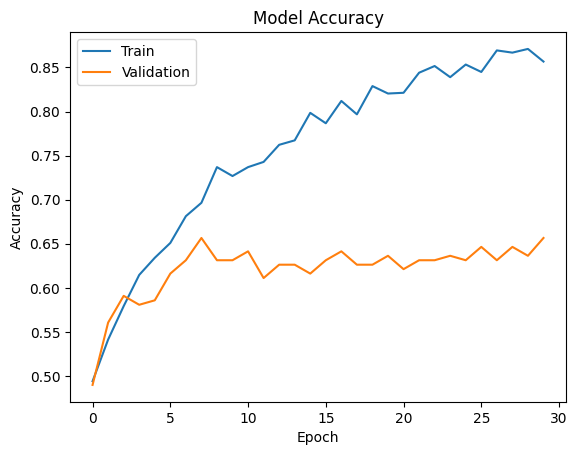

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


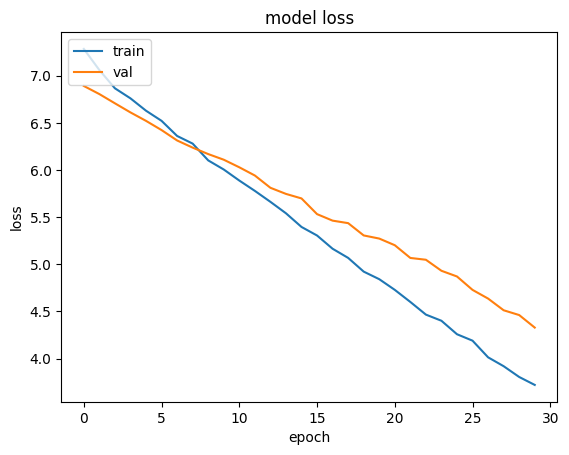

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Predict on the test data
y_pred_prob = model.predict([X_test_balanced])

# Convert probabilities to binary predictions (threshold 0.5 for sigmoid activation)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

# Calculate accuracy
accuracy = accuracy_score(y_test_balanced, y_pred)
print(f"Accuracy on test data: {accuracy:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
Accuracy on test data: 0.71
